<a href="https://colab.research.google.com/github/dbrody112/Mach_Learning_Remote_Sensing/blob/main/remote_sensing_proj1-Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installations and Dependencies**

In [ ]:

!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install rioxarray
!pip install geemap
!pip install geojson
!pip install geopandas

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

     |████████████████████████████████| 1.0MB 4.9MB/s 
     |████████████████████████████████| 15.3MB 536kB/s 


# **Aligning Dataset**

In [ ]:

import matplotlib.pyplot as plt
import rioxarray as rxr
import rasterio
from rasterio.crs import CRS
import glob
import subprocess
import urllib, geojson,subprocess,gdal
import geopandas as gpd
import shapefile
import os
import ee
import json
import numpy as np
import pandas as pd
import geemap
from rasterio.plot import show
import math
import osr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' gis_projects is where the original dataset and geojson are stored'''
'''in order to align you have to create a few folders in your drive. create folders with these names:

- revised_dataset_projected
- revised_dataset_resolution
- new_dataset

'''

'in order to align you have to create a few folders in your drive. create folders with these names:\n\n- revised_dataset_projected\n- revised_dataset_resolution\n- new_dataset\n\n'

In [ ]:
geojson_loc = '/content/drive/MyDrive/gis_projects/santafe_crop.geojson'
dataset_loc = '/content/drive/MyDrive/gis_projects'
projected_dataset_loc = '/content/drive/MyDrive/revised_dataset_projected'
resolution_dataset_loc = '/content/drive/MyDrive/revised_dataset_resolution'


# Summary

For the first step in aligning the dataset I reprojected files in dataset to EPSG:32316 because this is a UTM CRS, which was recommended by the professor, and also because upon exploration this projection was found in the dataset so it appears that the coordinate system is native to the images. After that, I changed the resolution of each image to 20m, since this was the maximum, such that no data will be lost. e.g. if an image at 20m was changed to a resolution of 10m the data may be lost. Additionally, I changed the resolution to this value such that less RAM is used in calculations involving the dataset. The next step was then to convert the geojson to a shapefile with the CRS specified (EPSG:32613) and crop to cutline

In [ ]:
#for loop to create a copy and paste script for command line to reproject files to utm (epsg:32613)

i = 0
for name in glob.glob(dataset_loc+'/*.tif'):
    print('gdalwarp -t_srs EPSG:32613' + " " +name+" " +projected_dataset_loc+'/i'+os.path.basename(name)[:-4]+str(i)+'utm'+'.tif')
    i+=1

#NOTE: Unfortunately I have been trying for about 10 hours in total to resolve issues with gdalwarp to no avail.
#The only way that I was able to reproject the dataset was to use the command line via colab pro.
#My drive is mounted so feel free to use those files or run all other portions of this code. They should work.
#Another option could be to skip the aligning dataset portion and use the new_dataset I have stored in my drive.


gdalwarp -t_srs EPSG:32613 /content/drive/MyDrive/gis_projects/sentinel-2_L1C_2018-01-07.tif /content/drive/MyDrive/revised_dataset_projected/isentinel-2_L1C_2018-01-070utm.tif
gdalwarp -t_srs EPSG:32613 /content/drive/MyDrive/gis_projects/sentinel-2_L1C_2018-01-12.tif /content/drive/MyDrive/revised_dataset_projected/isentinel-2_L1C_2018-01-121utm.tif
gdalwarp -t_srs EPSG:32613 /content/drive/MyDrive/gis_projects/sentinel-2_L1C_2018-01-14.tif /content/drive/MyDrive/revised_dataset_projected/isentinel-2_L1C_2018-01-142utm.tif
gdalwarp -t_srs EPSG:32613 /content/drive/MyDrive/gis_projects/sentinel-2_L1C_2018-01-27.tif /content/drive/MyDrive/revised_dataset_projected/isentinel-2_L1C_2018-01-273utm.tif
gdalwarp -t_srs EPSG:32613 /content/drive/MyDrive/gis_projects/sentinel-2_L1C_2018-01-29.tif /content/drive/MyDrive/revised_dataset_projected/isentinel-2_L1C_2018-01-294utm.tif
gdalwarp -t_srs EPSG:32613 /content/drive/MyDrive/gis_projects/sentinel-2_L1C_2018-02-08.tif /content/drive/MyDrive

In [ ]:
'''finding crs for the files projected to utm (as a check)'''

for name in glob.glob(projected_dataset_loc+'/*.tif'):
    dem = rxr.open_rasterio(name,masked=True).squeeze()
    print(name, dem.rio.crs)

In [ ]:
'''resolution exploration'''

#getting affine transform of tif
#upx is upper pixel x
#xes is pixel width
#xkew is shear in x direction
summation = 0
length = 0
maximum = 0
for name in glob.glob(projected_dataset_loc+'/*.tif'):
    ds = gdal.Open(name)
    upx, xres, xskew, upy, yskew, yres = ds.GetGeoTransform()
    print('the resolution of ' + os.path.basename(name) + " (" + str(xres) + ","+str(yres)+")." )
    if(xres>maximum):
        maximum = xres
print(" ")
print("the max resolution is " + str(maximum))

In [ ]:
'''changing resolution of all reprojected images to max resolution'''

i = 0
for name in glob.glob(projected_dataset_loc+'/*.tif'):
    args = ['gdal_translate','-of','GTiff','-tr',str(maximum),str(maximum),name,resolution_dataset_loc+'/i'+os.path.basename(name)[:-4]+str(i)+'res'+'.tif']
    subprocess.Popen(args)
    i+=1

In [ ]:
'''creating dataset of original names'''

names = []
for name in glob.glob(dataset_loc+'/*.tif'):
    names.append(os.path.basename(name))

In [ ]:
'''creating shapefile out of geojson and projecting it to epsg:32613'''

In [ ]:
!ogr2ogr /content/drive/MyDrive/gis_projects/output.shp -t_srs 'http://spatialreference.org/ref/epsg/4326/' /content/drive/MyDrive/gis_projects/santafe_crop.geojson

In [ ]:
'''cropping images to shapefile extent and changing name back to original'''

i = 0
for name in glob.glob(resolution_dataset_loc+'/*.tif'):
    if(len(os.path.basename(name)) == 39):
      file_name = os.path.basename(name)[:-12]
    elif(len(os.path.basename(name)) == 41):
      file_name = os.path.basename(name)[:-14]
    else:
      file_name = os.path.basename(name)[:-16]
    print(name)
    args = ['gdalwarp','-cutline','/content/drive/MyDrive/gis_projects/output.shp','-crop_to_cutline','-dstalpha',name,'/content/drive/MyDrive/new_dataset/i'+file_name+".tif"]
    subprocess.Popen(args)
    i+=1

# **Analyzing Dataset**

In [ ]:
#band 4 is nir
#band 1 is red
#band 7 is alpha

#loading in data

#for each file, the data is opened and the image height, width, bands, 
# and alpha band measurement are loaded into a stack.

dataset_array = []

for name in glob.glob("/content/drive/MyDrive/new_dataset/*.tif"):

  data = rasterio.open(name)

  #normalizing alpha band just in case

  alpha_band = np.mean(data.read()[6]/np.max(data.read()[6]))
  
  dataset_array.append([data.height,data.width,data.read(),alpha_band])

In [ ]:
data_array = np.stack(dataset_array)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
len(data_array)

102

In [ ]:
''' finding the range of values for each respective band '''

#creating array of dataset bands (in hindsight it may have been easier to use a column index)

dataset_bands = data_array[:,2]
band_distribution = []

#separating each band

for i in range(len(dataset_bands)):
  band_distribution.append([dataset_bands[i][j] for j in range(7)])
band_distribution = np.array(band_distribution)

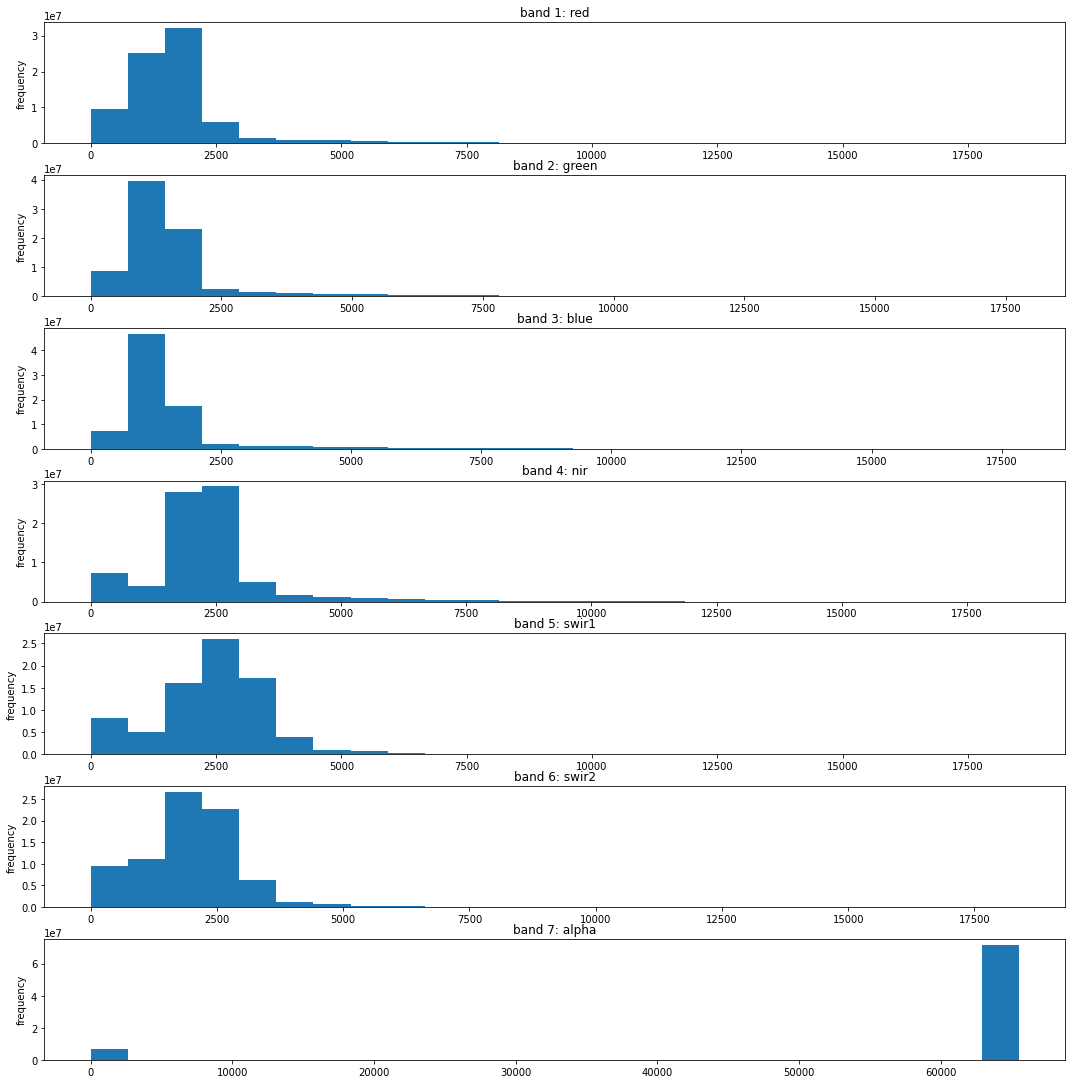

In [ ]:
'''creating histogram of values of images picked from aligned dataset'''

fig, axs = plt.subplots(7,1)

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
bands = {0:'red',1:'green',2:'blue',3:'nir',4:'swir1',5:'swir2',6:'alpha'}
for i in range(7):
  axs[i].hist(band_distribution[:,i].flatten().squeeze(),bins=25)
  axs[i].set_title("band " + str(i+1) + ": " + bands[i]) 
  axs[i].set_ylabel('frequency')
  


In [ ]:
'''computing cloud mask'''

def create_cloud_mask(img_array):

  '''creating cloud mask from blue band (band 3) and swir band (band 5).
  blue band identifies dense clouds with high reflectance and 
  swir band differentiates snow from cloud because snow can have a high
  reflectance in blue band but low reflectance in swir1 band'''

  '''
  INPUTS:

  img_array (.tif as array): the .tif you want to apply a cloud mask on

  OUTPUTS:

  cloud_mask_matrix: matrix with zeros (invalid data) at the places where a cloud is predicted

  ''' 

  #thresholding based on histogram. It took some testing and educated guesses based on th histogram but these were the best values
  #using np.where to find the points where over threshold
  #The way that I had guessed was to threshold at/after the largest peak of the histogram for the respective banf since I did not want to threshold out a
  # large portion of the data and, for the most part, it unlikely that the bin with the largest peak houses clouds, or at the very least dense clouds. 
  #Upon looking at the data, I found that a picture having large amount of dense clouds was generally rare overall

  blue = np.where(img_array[2] >=1250)
  swir1 = np.where(img_array[4] >=3000) 

  #finding where the points intersect between those that surpass the swir1 and blue

  df_blue = pd.DataFrame({'blue':[(blue[0][i],blue[1][i]) for i in range(len(blue[0]))]})
  df_swir1 = pd.DataFrame({'swir1':[(swir1[0][i],swir1[1][i]) for i in range(len(swir1[0]))]}) 
  df_merged = df_blue.merge(df_swir1,left_on = 'blue',right_on ='swir1')

  #creating cloud mask matrix starting with an array of 1s (valid data), putting 0s where a cloud is predicted

  cloud_mask_matrix = np.ones((np.shape(img_array[2])[0], np.shape(img_array[2])[1])).astype('uint16')
  print(len(df_merged['blue']))
  for i in df_merged['blue']:
    arr = np.array(i)
    cloud_mask_matrix[arr[0]][arr[1]] = 0
  return cloud_mask_matrix

def create_cloud_arr(image_stack):
  ''' applying create_cloud_mask function'''

  '''
  INPUTS:
  
  image_stack: np.stack of .tifs as arrays where each array has a length of n, 
  the number of bands

  OUTPUTS:

  alpha_band_arr: updated alpha band with cloud mask added
  thresholded_points: number of points predicted to be part of the cloud from the cloud mask.

  '''

  alpha_band_arr = []
  num_thresholded_points = []
  for i in range(len(image_stack)):

    #creating cloud mask for an individual image

    cloud_mask = create_cloud_mask(image_stack[i])

    #finding the number of points predicted in the image as cloud

    num_thresholded_points.append(np.shape(cloud_mask)[0]*np.shape(cloud_mask)[1] - np.sum(cloud_mask))

    #final result

    alpha_band_arr.append(cloud_mask*image_stack[i][6].astype('bool').astype('uint16'))
  return alpha_band_arr,num_thresholded_points

In [ ]:
#creating cloud masks for each file and storing in an array

cloud_mask_arr, num_thresholded_points= create_cloud_arr(data_array[:,2])

In [ ]:


#This function, rescale_img, was specifically taken from Professor Karra from his lecture on Week 5.
#there is no link to go to but if you are in the Remote Sensing class you can find the function through Teams and/or Google Drive

def rescale_img(img, min_val=0.0, max_val=1.0, dtype=np.float32, pmin=0.0, pmax=100.0):
    vmin, vmax = np.nanpercentile(img, pmin), np.nanpercentile(img, pmax)

    
    img_rescale = ((img - vmin) * (1.0 / (vmax - vmin) * max_val)).astype(dtype)
    np.clip(img_rescale, min_val, max_val, out=img_rescale)

    return img_rescale

#helper function to shorthand rescale_img with specific parameters

image_rescaled = lambda x: rescale_img(x,pmin = 0.2,pmax = 99.8)


def show_image(picture_num,band,name = None,cloud_mask = None):

  '''showing image with a comparison between original and cloud mask'''

  '''

  INPUTS:

  picture_num: (int) index of image stack loaded in (used to isolate individual images)
  band: (int) band of image to use e.g. band = 0 is the red band

  '''


  alpha_band = (data_array[:,2][picture_num][6].astype('bool')).astype('uint16')
  data_validation = cloud_mask_arr[picture_num]*alpha_band
  cloud_mask_picture = image_rescaled(data_array[:,2][picture_num][band]*(data_validation))

  

  #plots image with cloud mask
  if(cloud_mask!= None):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    axs[1].imshow(cloud_mask_picture,cmap = 'cividis')
    axs[1].set_title('with cloud mask')

    #plots image without cloud mask

    axs[0].imshow(rescale_img(data_array[:,2][picture_num][band]*(alpha_band),pmin=0.2, pmax=99.8),cmap = 'cividis')
    if(name!=None):
      axs[0].set_title(name)
    else:
      axs[0].set_title('without cloud mask')
  else:
    fig = plt.figure(figsize=(8,8))

    plt.imshow(rescale_img(data_array[:,2][picture_num][band]*(alpha_band),pmin=0.2, pmax=99.8),cmap = 'cividis')
    if(name!=None):
      plt.title(name)
    else:
      plt.title('without cloud mask')



TEST_IMAGE

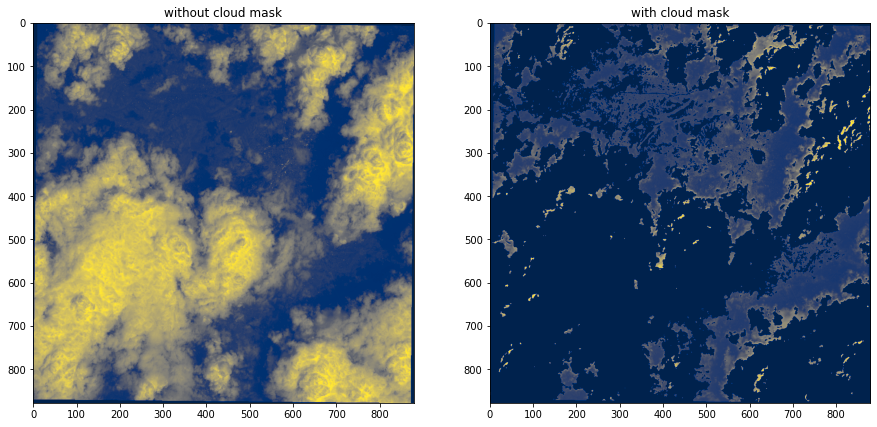

In [ ]:
show_image(picture_num =80, band = 2,cloud_mask = True)

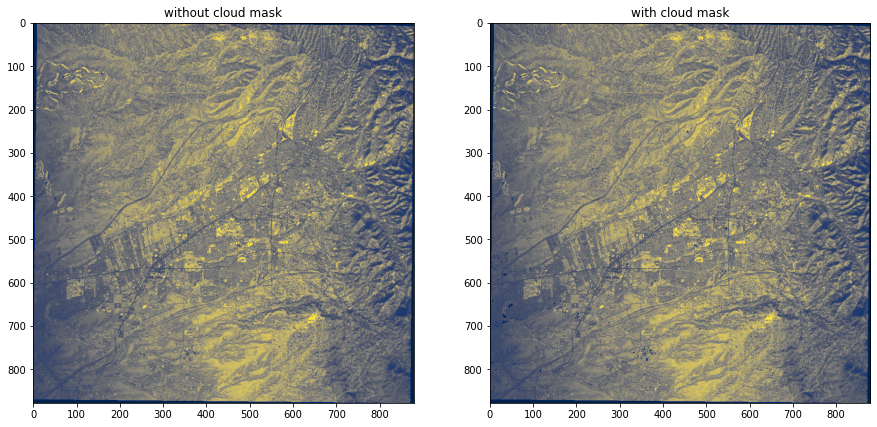

In [ ]:
show_image(picture_num =100, band = 2,cloud_mask =True)

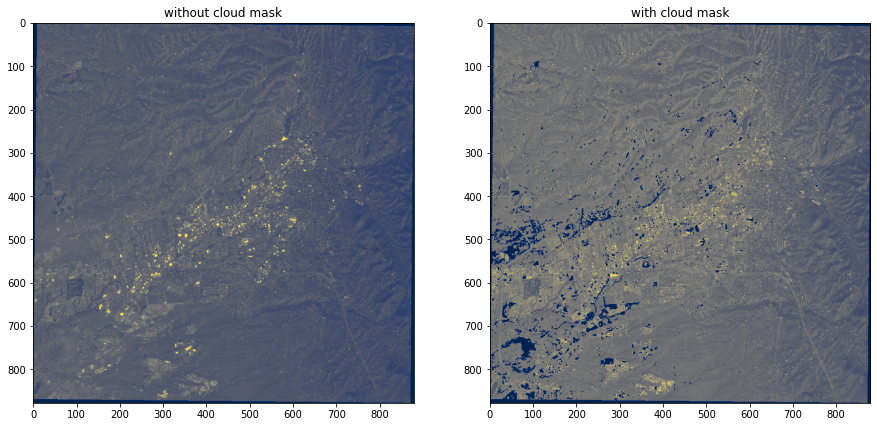

In [ ]:
show_image(picture_num =60, band = 2,cloud_mask =True)

I ultimately chose this cloud mask to use for the composites and part 1, however it does have its strengths and weaknesses. When there is a large amount of dense cloud, the mask performs relatively well, capturing most of the cloud (as shown by picture 1). Additionally, due to the SWIR band being used, snow can easily be differentiated from clouds and is not detected as cloud (as shown by picture 2). The largest weakness, however, can be found in the last picture where much of the scene that is not cloud is classified as cloud.

PART 1 FUNCTIONS

In [ ]:
def apply_cloud_mask(picture_num,band):

  ''' 
  applying cloud mask to picture num and band
  
  '''

  '''
  INPUTS:

  picture_num: (int) index of image stack loaded in (used to isolate individual images)
  band: (int) band of image to use e.g. band = 0 is the red band

  OUTPUTS:

  returns image band with applied cloud mask

  '''

  alpha_band = (data_array[:,2][picture_num][6].astype('bool')).astype('uint16')
  data_validation = cloud_mask_arr[picture_num]*alpha_band
  return data_array[:,2][picture_num][band]*data_validation





def calculate_greenest_scene(cloud_mask_arr,max_or_mean = 'mean'):

  '''calculates the image with the best ndvi based on the max or mean of the image, default mean.
  The image will have a cloud mask derived from the swir and blue band so that 
  invalid data will not be part of the mean. I personally defined greenest scene as the greatest mean(ndvi)
  because if we define only on max(NDVI) then there is a possibility that only a small portion of the image is green.
  I have it so that you can specify max or mean since people have different interpretations of greenest scene. Note:
  if you are worried about the cloud mask for the max option, it will have no effect. If a scene truly has an area where there is max NDVI, 
  it will not have a high reflectance in the swir and blue band and therefore not be invalid by the cloud mask.'''
  
  '''
  INPUTS:

  cloud_mask_arr : (array) array of cloud masks which can be made by using the create_cloud_arr function
  max_or_mean : (string) if this variable is equivalent to 'mean' it computes the mean. Elsewise it computes the max.

  OUTPUTS:

  greenest_scene_val: (int) the best NDVI based on whichever option chosen (max or mean)
  greenest_scene_picture_num: (int) the picture for which there is the best NDVI ased on whichever option chosen (max or mean)
  '''

  #computing ndvi for each image. There is an initial value of -10000 for NDVI and -1 for the picture number.
  #the picture number is just used as an index to isolate a specific image in the stack of images imported.
  #If an ndvi is greater than the last NDVI that was appended to maximum then it is appended as well as its corresponding picture number.
  #In this way the last entry of maximum includes the max ndvi and picture with max ndvi

  maximum = []
  maximum.append([-10000,-1])
  for i in range(len(cloud_mask_arr)):

    #getting bands for calculation

    red = apply_cloud_mask(i,0)
    nir = apply_cloud_mask(i,3)

    #calculating ndvi

    aggregated_ndvi = 0
    ndvi = ((nir-red)/(nir+red))
    ndvi = ndvi.flatten()
    ndvi = [ndvi[i] if ndvi[i]<1 else -1 for i in range(len(ndvi))]
    if(max_or_mean == 'max'):
      aggregated_ndvi = np.nanmax(ndvi)
    else:
      aggregated_ndvi = np.nanmean(ndvi)
    
    #appending max ndvi if greater than last value of maximum

    if(aggregated_ndvi>maximum[len(maximum)-1][0]):
      maximum.append([aggregated_ndvi,i,ndvi])


  greenest_scene_val = maximum[len(maximum)-1][0]
  greenest_scene_picture_num = maximum[len(maximum)-1][1]
  return greenest_scene_val,greenest_scene_picture_num


#snow 

def calculate_snowiest_scene(cloud_mask_arr,max_or_mean = 'mean'):

  '''calculates the image with the best ndsi based on the max or mean of the image, default mean.
  The image will have a cloud mask derived from the swir and blue band so that 
  invalid data will not be part of the mean. I personally defined greenest scene as the greatest mean(ndsi)
  because if we define only on max(NDSI) then there is a possibility that only a small portion of the image is green.
  I have it so that you can specify max or mean since people have different interpretations of greenest scene. Note:
  if you are worried about the cloud mask for the max option, it should have no effect. If a scene truly has an area where there is max NDSI, 
  then it will have a low reflectance in the swir band and therefore not be invalid by the cloud mask.'''
  
  '''
  INPUTS:

  cloud_mask_arr : (array) array of cloud masks which can be made by using the create_cloud_arr function
  max_or_mean : (string) if this variable is equivalent to 'mean' it computes the mean. Elsewise it computes the max.

  OUTPUTS:

  snowiest_scene_val: (int) the best NDSI based on whichever option chosen (max or mean)
  snowiest_scene_picture_num: (int) the picture for which there is the best NDSI based on whichever option chosen (max or mean)
  '''

  #computing ndsi for each image. There is an initial value of -10000 for NDsI and -1 for the picture number.
  #the picture number is just used as an index to isolate a specific image in the stack of images imported.
  #If an ndsi is greater than the last NDsI that was appended to maximum then it is appended as well as its corresponding picture number.
  #In this way the last entry of maximum includes the max ndsi and picture with max ndsi

  maximum = []
  maximum.append([-10000,-1])
  for i in range(len(cloud_mask_arr)):

    #getting bands for calculation

    green = apply_cloud_mask(i,1)
    swir1 = apply_cloud_mask(i,4)

    #calculating ndsi

    aggregated_ndsi = 0
    ndsi = ((green-swir1)/(green+swir1))
    ndsi = ndsi.flatten()
    ndsi = [ndsi[i] if ndsi[i]<1 else -1 for i in range(len(ndsi))]
    if(max_or_mean == 'max'):
      aggregated_ndsi = np.nanmax(ndsi)
    else:
      aggregated_ndsi = np.nanmean(ndsi)
    
    #appending max ndsi if greater than last value of maximum


    if(aggregated_ndsi>maximum[len(maximum)-1][0]):
      maximum.append([aggregated_ndsi,i,ndsi])


  snowiest_scene_val = maximum[len(maximum)-1][0]
  snowiest_scene_picture_num = maximum[len(maximum)-1][1]
  return snowiest_scene_val,snowiest_scene_picture_num


def calculate_max_brightness(cloud_mask_arr,max_or_mean = 'mean'):

  '''calculates the image with the best brightness based on the max or mean of the image, default mean.
   The image will have a cloud mask derived from the swir and blue band so that 
  invalid data will not be part of the mean. I personally defined greenest scene as the greatest mean(ndsi)
  because if we define only on max(brightness) then there is a possibility that only a small portion of the image is very bright.
  I have it so that you can specify max or mean since people have different interpretations of greenest scene.'''
  
  '''
  INPUTS:

  cloud_mask_arr : (array) array of cloud masks which can be made by using the create_cloud_arr function
  max_or_mean : (string) if this variable is equivalent to 'mean' it computes the mean. Elsewise it computes the max.

  OUTPUTS:

  snowiest_scene_val: (int) the best NDSI based on whichever option chosen (max or mean)
  snowiest_scene_picture_num: (int) the picture for which there is the best NDSI based on whichever option chosen (max or mean)
  '''

  maximum = []
  maximum.append([-10000,-1])
  for i in range(len(cloud_mask_arr)):
    
    red = apply_cloud_mask(i,0)
    green = apply_cloud_mask(i,1)
    blue = apply_cloud_mask(i,2)
    brightness = 0
    visible_light = (red+green+blue)/3
    
    if(max_or_mean == 'max'):
      brightness = np.nanmax(visible_light)
    else:
      brightness = np.nanmean(visible_light)
    
    if(brightness>maximum[len(maximum)-1][0]):
      maximum.append([brightness,i,visible_light])
  brightness_max = maximum[len(maximum)-1][0]
  max_brightness_picture_num = maximum[len(maximum)-1][1]
  return brightness_max,max_brightness_picture_num

GREENEST_SCENE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


 
the picture with max ndvi is iiisentinel-2_L1C_2018-10-26.tif with 0.18020856521979414.
 


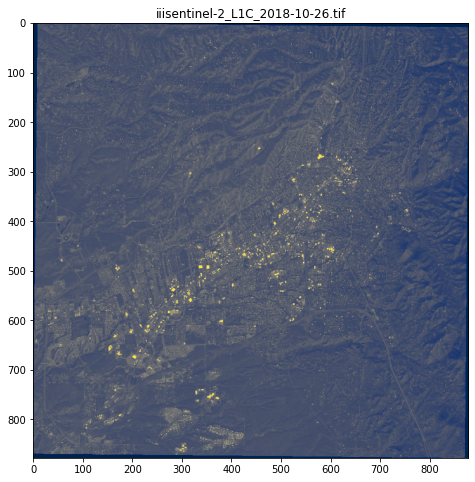

In [ ]:
arr = []
for name in glob.glob('/content/drive/MyDrive/new_dataset/*.tif'):
  arr.append(name)

greenest_scene_val,greenest_scene_picture_num = calculate_greenest_scene(cloud_mask_arr)
show_image(greenest_scene_picture_num, band = 1,name = os.path.basename(arr[greenest_scene_picture_num]))
print(' ')
print(f'the picture with max ndvi is {os.path.basename(arr[greenest_scene_picture_num])} with {greenest_scene_val}.')
print(' ')

SNOWIEST_SCENE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide


 
the picture with max ndsi is iiisentinel-2_L1C_2018-12-13.tif with 0.4097505984090447.
 


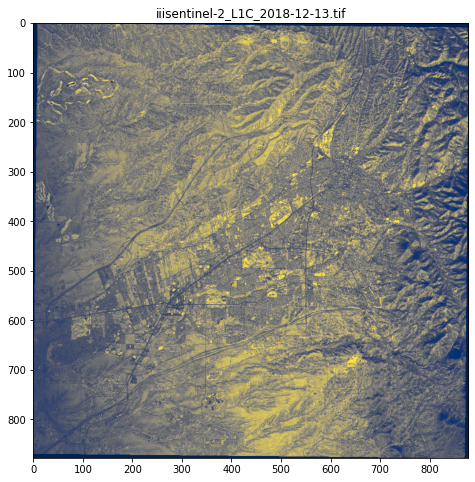

In [ ]:
snowiest_scene_val,snowiest_scene_picture_num= calculate_snowiest_scene(cloud_mask_arr)
show_image(snowiest_scene_picture_num, band = 1,name = os.path.basename(arr[snowiest_scene_picture_num]))
print(' ')
print(f'the picture with max ndsi is {os.path.basename(arr[snowiest_scene_picture_num])} with {snowiest_scene_val}.')
print(' ')

CLOUDIEST_IMAGE

 
the cloudiest picture is iiisentinel-2_L1C_2018-11-10.tif with sum of 670352.
 


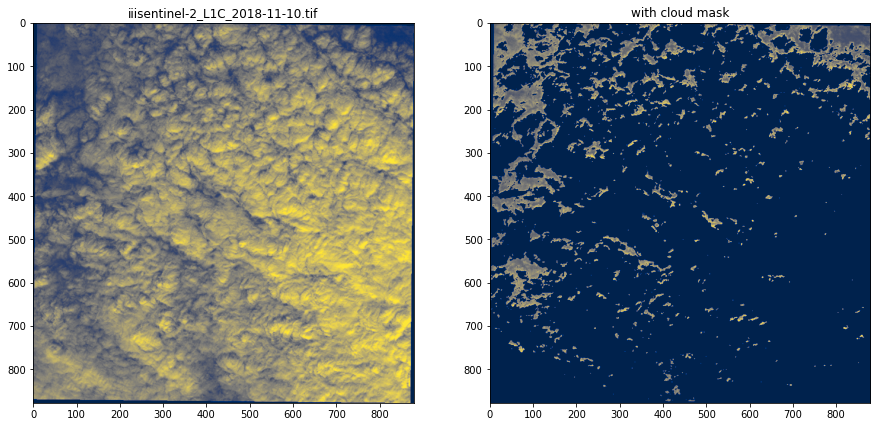

In [ ]:
cloudiest_image_index = np.where(num_thresholded_points == max(num_thresholded_points))[0][0]
cloudiest_image_value = num_thresholded_points[cloudiest_image_index]
show_image(cloudiest_image_index, band = 2,name = os.path.basename(arr[cloudiest_image_index]),cloud_mask = True)
print(' ')
print(f'the cloudiest picture is {os.path.basename(arr[cloudiest_image_index])} with sum of {int(cloudiest_image_value)}.')
print(' ')

BRIGHTEST_IMAGE

 
the picture with max brightness is iiisentinel-2_L1C_2018-12-13.tif with 3346.5136138688704.
 


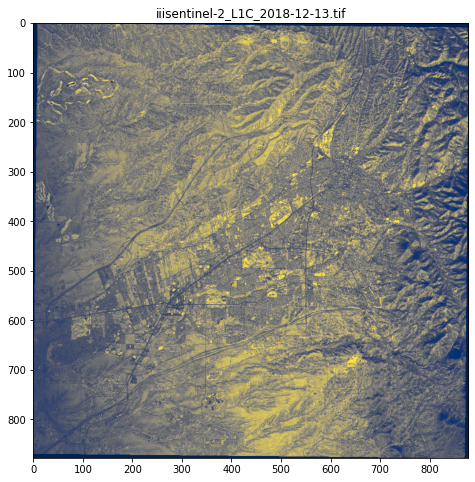

In [ ]:

brightness_max,max_brightness_picture_num = calculate_max_brightness(cloud_mask_arr)
show_image(max_brightness_picture_num, band = 1,name = os.path.basename(arr[max_brightness_picture_num]))
print(' ')
print(f'the picture with max brightness is {os.path.basename(arr[max_brightness_picture_num])} with {brightness_max}.')
print(' ')

# Conclusions and Explanations

In conclusion, I have utilized seven bands to compute a cloud mask, the greenest scene, the snowiest scene, the cloudiest scene, and the brightest scene. As for the greenest scene I applied the maximum NDVI mean for each image. The reason to have maximum mean over maximum max is because for maximum max, all an image needs is one point that has a very high NDVI, as opposed to maximum mean that has to have an average greenest scene. The same logic can apply to the snowiest scene, where we use NDSI to compute the snowiest scene, hence I also used maximum mean in this area. The cloudiest scene was found using my cloud mask. In my cloud mask function I was able to compute the number of thresholded points and output them for each image as well as output each cloud mask for each image. More info can be found if you read the decsription under create_cloud_arr. The brightest scene can be found by adding up RGB (Red, Green, Blue). Brightness can range from 0 (dark) to 255 (white) so in averaging the red ,green, and blue band one can receive brightness. I measured brightness as I did the other metrics, through the maximum mean, for the same reasons, that one point could make a difference instead of the whole image.

# COMPOSITES

Note: need to make a "composites" folder here

# Summary

As for the composites, I plan to retain all of the pictures that have a certain percentage of the image valid once the cloud mask is applied. The reason for this is that having too much invalid data can largely skew measures such as median and mean. I plan to create a histogram of those values across the whole dataset in order to determine the threshold. As I have already completed the histogram (shown below) I can tell you I used a threshold of 0.6. The reason I chose this threshold (in this case getting rid of all of those below) is that a large part of my data is at least 65-70% valid data so I chose a threshold where I would retain the dataset and also receive good composites

Text(0, 0.5, 'frequency')

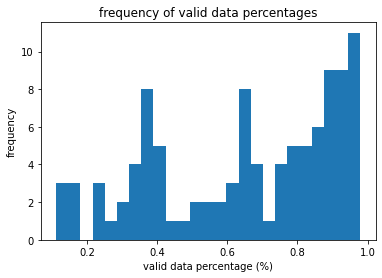

In [ ]:
#for the composites let us get threshold the alpha band to get rid of a a large amount of invalid data (at least for the statistics composites) because those will skew statistics such as mean and median

#creating a histogram of values for mean(alpha band) when cloud mask applied to figure out a threshold

alpha_band = []
for i in range(len(cloud_mask_arr)):
  alpha = (data_array[:,2][i][6].astype('bool')).astype('uint16')
  alpha_band.append(np.mean(cloud_mask_arr[i]*alpha))
plt.hist(alpha_band,bins = 25)
plt.title('frequency of valid data percentages')
plt.xlabel('valid data percentage (%)')
plt.ylabel('frequency')

In [ ]:
#using a threshold 0f 0.6, as shown from the graph

revised_data_array = []
for i in range(len(cloud_mask_arr)):

  #thresholding

  if(alpha_band[i]>=0.6):
    data_array[:,2][i][6] = cloud_mask_arr[i]

    #applying cloud mask to bands (except alpha)

    for j in range(5):
      data_array[:,2][i][j] = data_array[:,2][i][j]*cloud_mask_arr[i]
    revised_data_array.append(data_array[:,2][i])

CONVERTING TO GTIFF

In [ ]:
for name in glob.glob('/content/drive/MyDrive/new_dataset/*.tif'):
  dataset = gdal.Open(name)
  break;

#such that there is no confusion, this code has similar logic to that of github user jkatagi for his code at https://gist.github.com/jkatagi/a1207eee32463efd06fb57676dcf86c8
#I am in no means trying to copy it, just using the logic but I would like to cite the user so this does not look like plagiarism

def arrayToTif(path_name,composite,dataset):

  ''' converts an array of shape (7,width,height) to a tif '''

  '''
  INPUTS:

  path_name: (string) the name of the tif along with where it will be saved
  composite: (array of size (7,width,height)) array to convert to a tif
  dataset: (gdal object) tif loaded in through gdal or rasterio from original dataset (used for projection, geotransform, etc.)

  '''
  rows = np.shape(composite[0])[0]
  cols = np.shape(composite[1])[1]
  upx, xres, xskew, upy, yskew, yres = dataset.GetGeoTransform()
  driver = gdal.GetDriverByName('GTiff')
  GDT_dtype = gdal.GDT_UInt16
  band_num = 7
  out = driver.Create(path_name,cols, rows, band_num, GDT_dtype)
  out.SetGeoTransform((upx, xres, xskew, upy, yskew, yres))
  for band in range(band_num):
    outBand = out.GetRasterBand(band+1)
    outBand.WriteArray(composite[band]) 
  projection = dataset.GetProjection()
  outSRS = osr.SpatialReference(wkt=projection)
  outBand.FlushCache()

MEAN_COMPOSITE

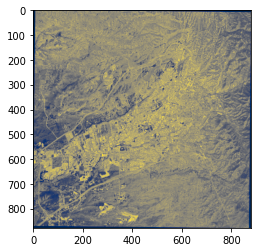

In [ ]:
mean_composite = np.mean(revised_data_array,axis = 0)
arrayToTif(path_name = '/content/drive/MyDrive/composites/mean_composite.tif', composite = mean_composite, dataset = dataset)
plt.imshow(image_rescaled(np.mean(revised_data_array,axis = 0)[0]),cmap = 'cividis')

MIN_COMPOSITE

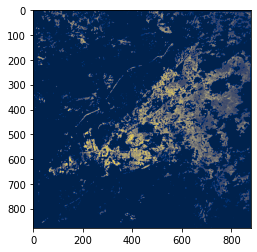

In [ ]:
min_composite = np.min(revised_data_array,axis = 0)
arrayToTif(path_name = '/content/drive/MyDrive/composites/min_composite.tif', composite = min_composite, dataset = dataset)
plt.imshow(image_rescaled(np.min(revised_data_array,axis = 0)[0]),cmap = 'cividis')

MAX_COMPOSITE

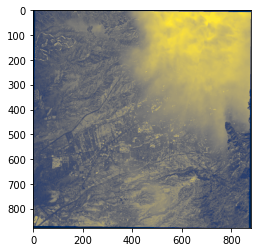

In [ ]:
max_composite = np.max(revised_data_array,axis = 0)
arrayToTif(path_name = '/content/drive/MyDrive/composites/max_composite.tif', composite = max_composite, dataset = dataset)
plt.imshow(image_rescaled(np.max(revised_data_array,axis = 0)[0]),cmap = 'cividis')

MEDIAN_COMPOSITE

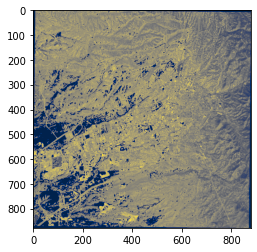

In [ ]:
median_composite = np.median(revised_data_array,axis = 0)
arrayToTif(path_name = '/content/drive/MyDrive/composites/median_composite.tif', composite = median_composite, dataset = dataset)
plt.imshow(image_rescaled(np.median(revised_data_array,axis = 0)[0]),cmap = 'cividis')

NDVI_COMPOSITE

In [ ]:
#finding the maximum NDVI values as a preliminary step to possibly minimize the amount 
#of time to calculate the positions used for the composite

red = [revised_data_array[i][0] for i in range(len(revised_data_array))]
nir = [revised_data_array[i][3] for i in range(len(revised_data_array))]
ndvi = (np.subtract(nir,red)/np.add(nir,red))
max_ndvi_vals = np.nanmax(ndvi,axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


In [ ]:
#finding the points to use out of all images such that the NDVI at each point is the greatest 
#among all other images with the same point

ndvi_composite_coords = []

j = 0
for j in range(np.shape(max_ndvi_vals)[0]):
  print(j)
  for k in range(np.shape(max_ndvi_vals)[1]):

    #finding the maximum at each position in the array

    list_comp = [ndvi[i][j][k] for i in range(len(revised_data_array))]
    maximum = np.nanmax(list_comp)

    #using np.where to figure out which image the point is from and j and k for the x and y coordinates.
    #in this case nans are unnecessary to log. If a position is not accounted for it is a nan.

    if(math.isnan(maximum)== False):
      ndvi_composite_coords.append([(np.where(list_comp == maximum))[0][0],j,k])
      
  

In [ ]:
#creating a dataframe to save time if program crashes

ndvi_composite_coords = np.array(ndvi_composite_coords)
argmax_ndvi_df = pd.DataFrame({'picture_num':ndvi_composite_coords[:,0],'x':ndvi_composite_coords[:,1], 'y':ndvi_composite_coords[:,2]})
argmax_ndvi_df.to_csv('/content/drive/MyDrive/argmax_ndvi_df.csv')

In [ ]:
#generating composite from array of positions

df = pd.read_csv('/content/drive/MyDrive/argmax_ndvi_df.csv')
ndvi_composite = np.empty((7,np.shape(max_ndvi_vals)[0],np.shape(max_ndvi_vals)[1]))
ndvi_composite[:] = math.nan

for j in range(7):
  print(j)
  for i in range(len(df)):
    ndvi_composite[j][df['x'][i]][df['y'][i]] = revised_data_array[df['picture_num'][i]][j][df['x'][i]][df['y'][i]]


In [ ]:
arrayToTif(path_name = '/content/drive/MyDrive/composites/ndvi_composite.tif', composite = ndvi_composite, dataset = dataset)

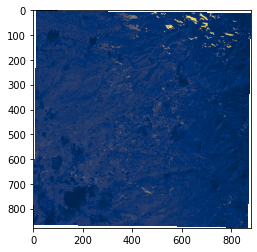

In [ ]:
plt.imshow(image_rescaled(ndvi_composite[0]),cmap = 'cividis')

85% NDVI_COMPOSITE

In [ ]:

#finding the points to use out of all images such that the NDVI at each point is 85% 
#among all other images with the same point

eighty_five_percent_ndvi_composite_coords = []

j = 0
for j in range(np.shape(max_ndvi_vals)[0]):
  print(j)
  for k in range(np.shape(max_ndvi_vals)[1]):
    list_comp = [ndvi[i][j][k] for i in range(len(revised_data_array))]

    #loading data into datafram for data manipulation

    df = pd.DataFrame({'ndvi_subset':list_comp})

    #dropping null values

    df.dropna(inplace = True)

    #sorting values in ascending order

    df.sort_values(by='ndvi_subset',inplace = True)
    final_array = np.array(df['ndvi_subset'])

    #retrieving value at 85% NDVI

    pos = int(len(final_array)*.85)
    eighty_five_percent = 0
    try:
      eighty_five_percent = final_array[pos]
    except:
      continue
    
    eighty_five_percent_ndvi_composite_coords.append([np.where(list_comp == eighty_five_percent)[0][0],j,k])
    

In [ ]:
#creating a dataframe to save time if program crashes
eighty_five_percent_ndvi_composite_coords = np.array(eighty_five_percent_ndvi_composite_coords)
eighty_five_percent_ndvi_df = pd.DataFrame({'picture_num':eighty_five_percent_ndvi_composite_coords[:,0],'x':eighty_five_percent_ndvi_composite_coords[:,1],'y':eighty_five_percent_ndvi_composite_coords[:,2]})

eighty_five_percent_ndvi_df.to_csv('/content/drive/MyDrive/eighty_five_percent_ndvi_df.csv')

In [ ]:
#generating composite from array of positions

df = pd.read_csv('/content/drive/MyDrive/eighty_five_percent_ndvi_df.csv')

eighty_five_ndvi_composite = np.empty((7,np.shape(max_ndvi_vals)[0],np.shape(max_ndvi_vals)[1]))
eighty_five_ndvi_composite[:] = math.nan
for j in range(7):
  print(j)
  for i in range(len(df)):
    eighty_five_ndvi_composite[j][df['x'][i]][df['y'][i]] = revised_data_array[df['picture_num'][i]][j][df['x'][i]][df['y'][i]]

In [ ]:
arrayToTif(path_name = '/content/drive/MyDrive/composites/eighty_five_ndvi_composite.tif', composite = eighty_five_ndvi_composite, dataset = dataset)

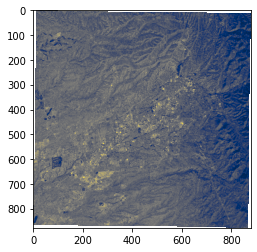

In [ ]:
plt.imshow(image_rescaled(eighty_five_ndvi_composite[0]),cmap = 'cividis')